<a href="https://colab.research.google.com/github/wSedler/Clustering_of_borrowers/blob/main/clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
matplotlib.style.use('ggplot')
%matplotlib inline

Ссылка на google disc https://drive.google.com/file/d/1MG7ImhVqd7yLSWMV01gROnQIebxe4qQZ/view?usp=sharing

In [2]:
!gdown --id 1MG7ImhVqd7yLSWMV01gROnQIebxe4qQZ

Downloading...
From: https://drive.google.com/uc?id=1MG7ImhVqd7yLSWMV01gROnQIebxe4qQZ
To: /content/data.csv
100% 3.32M/3.32M [00:00<00:00, 52.5MB/s]


In [3]:
df = pd.read_csv('/content/data.csv')

In [4]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


## Предобработка данных

Обработка "children"


In [5]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Значения 20 и -1 ошибочны, скорее всего это опечатки. (20 это 2, а -1 это 1)

In [6]:
df.loc[df['children'] == 20, 'children'] = 2

In [7]:
df.loc[df['children'] == -1, 'children'] = 1

In [8]:
df['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

Обработка "days_employed"


In [9]:
df['days_employed'].isna().sum()

2174

In [10]:
df[(df['days_employed'].isna()) & (df['total_income'].isna())]['purpose'].count()

2174

Отсутствие значений days_employed и total_income взаимосвязаны

In [11]:
df[df['days_employed'] > 0].head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
18,0,400281.136913,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.777243,на покупку подержанного автомобиля
24,1,338551.952911,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547.235997,операции с коммерческой недвижимостью
25,0,363548.489348,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.757732,покупка недвижимости
30,1,335581.668515,62,среднее,1,женат / замужем,0,F,пенсионер,0,171456.067993,операции с коммерческой недвижимостью
35,0,394021.072184,68,среднее,1,гражданский брак,1,M,пенсионер,0,77805.677436,на проведение свадьбы
50,0,353731.432338,63,среднее,1,женат / замужем,0,F,пенсионер,0,92342.730612,автомобили
56,0,370145.087237,64,среднее,1,вдовец / вдова,2,F,пенсионер,0,149141.043533,образование
71,0,338113.529892,62,среднее,1,женат / замужем,0,F,пенсионер,0,43929.696397,автомобили
78,0,359722.945074,61,высшее,0,женат / замужем,0,M,пенсионер,0,175127.646000,сделка с автомобилем


In [12]:
df[df['days_employed'] > 0]['dob_years'].count()

3445

In [13]:
df[(df['income_type'] == 'пенсионер') & (df['days_employed'] > 0)]['dob_years'].count()

3443

In [14]:
df[(df['income_type'] != 'пенсионер') & (df['days_employed'] > 0)]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
3133,1,337524.466835,31,среднее,1,женат / замужем,0,M,безработный,1,59956.991984,покупка жилья для сдачи
14798,0,395302.838654,45,Высшее,0,гражданский брак,1,F,безработный,0,202722.511368,ремонт жилью


In [15]:
df[df['income_type'] == 'безработный']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
3133,1,337524.466835,31,среднее,1,женат / замужем,0,M,безработный,1,59956.991984,покупка жилья для сдачи
14798,0,395302.838654,45,Высшее,0,гражданский брак,1,F,безработный,0,202722.511368,ремонт жилью


Все значения больше нуля принадлежат пенсионерам или безработным, т.е. тем, кто не работает


In [16]:
df[df['income_type'] == 'пенсионер']['income_type'].count()

3856

In [17]:
df[(df['days_employed'].isna() == True) & (df['income_type'] == 'пенсионер')]['purpose'].count()

413

Пенсионеры имеют "days_employed" либо больше нуля, либо не имеют вовсе

In [18]:
df[df['income_type'] == 'пенсионер']['days_employed'].mean()

365003.49124486075

In [19]:
df[df['income_type'] == 'пенсионер']['dob_years'].mean()

59.06301867219917

In [20]:
df[df['income_type'] == 'пенсионер']['days_employed'].mean() / 24 / 365.25

41.638545658779464

Если предположить, что days_employed > 0 это значения в часах, то в среднем люди работали 24 часа на протяжении 41 года с 18 лет, что невозожно.  
Не будем использовать столбец days_employed из-за аномалных значений

Обработка dob_years


In [21]:
df['dob_years'].value_counts().sort_index().head(10)

0     101
19     14
20     51
21    111
22    183
23    254
24    264
25    357
26    408
27    493
Name: dob_years, dtype: int64

Удалим аномальное значение 0 лет

In [22]:
df = df.query('dob_years != 0')

Приведение "education" к строчным буквам


In [23]:
df.loc[:, 'education'] = df['education'].str.lower()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [24]:
df.loc[:, 'education']

0         высшее
1        среднее
2        среднее
3        среднее
4        среднее
          ...   
21520    среднее
21521    среднее
21522    среднее
21523    среднее
21524    среднее
Name: education, Length: 21424, dtype: object

Обработка gender

In [25]:
df['gender'].value_counts()

F      14164
M       7259
XNA        1
Name: gender, dtype: int64

Женщин в 2 раза больше чем мужчин.  
Удалим значение XNA

In [26]:
df = df.query('gender != "XNA"')

**Вывод**

- Пропуски в days_employed и total_income взаимосвязанны
- Обнаружены артефакты в children, days_employed, dob_years, gender
- Замена на строчные буквы в education
- Женщин в 2 раза больше мужчин

In [27]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz

--2021-11-21 14:05:58--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.241, 5.45.205.244, 5.45.205.242, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.241|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-man01i.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2021-11-21 14:05:59--  http://cache-man01i.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-man01i.cdn.yandex.net (cache-man01i.cdn.yandex.net)... 5.45.205.221, 2a02:6b8::3:221
Connecting to cache-man01i.cdn.yandex.net (cache-man01i.cdn.yandex.net)|5.45.205.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.4’

mystem-3.0-linux3.1 100%[===================>]  15.70M 

В этом месте иногда приходится перезапускать

In [28]:
!cp mystem /root/.local/bin/mystem

In [29]:
from pymystem3 import Mystem
m = Mystem()

In [30]:
unique = ' '.join(df['purpose'].unique())

In [31]:
lemmas = m.lemmatize(unique)

In [32]:
from collections import Counter
print(Counter(lemmas)) 

Counter({' ': 96, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, '\n': 1})


In [33]:
def replace(row):
    purpose = row['purpose']
  
    lemmas = m.lemmatize(purpose)
    if ('жилье' in lemmas) or ('недвижимость' in lemmas):
        return 'на недвижимость'
    if 'автомобиль' in lemmas:
        return 'на автомобиль'
    if 'образование' in lemmas:
        return 'на образование'
    if 'свадьба' in lemmas:
        return 'на свадьбу'

In [34]:
df['purpose'] = df.apply(replace, axis=1)

In [35]:
df['purpose'].count()

21423

In [36]:
def id(row):
  if row == 'на недвижимость':
    return 0
  if row == 'на автомобиль':
    return 1
  if row == 'на образование':
    return 2
  return 3

In [37]:
df['purpose_id'] = df['purpose'].apply(id)

In [38]:
def f_gen_id(row):
  if row == 'F':
    return 0
  return 1

In [39]:
df['gender_id'] = df['gender'].apply(f_gen_id)

In [40]:
df.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_id,gender_id
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,на недвижимость,0,0
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,на автомобиль,1,0
2,0,-5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,на недвижимость,0,1
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,на образование,2,1
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,на свадьбу,3,0


## Иерархическая кластеризация

In [41]:
pre_df = df[['children', 'dob_years', 'education_id', 'family_status_id', 'gender_id', 'purpose_id', 'total_income']]

In [42]:
pre_df = pre_df.dropna()

In [43]:
pre_df.head()

,children,dob_years,education_id,family_status_id,gender_id,purpose_id,total_income
0,1,42,0,0,0,0,253875.639453
1,1,36,1,0,0,1,112080.014102
2,0,33,1,0,1,0,145885.952297
3,3,32,1,0,1,2,267628.550329
4,0,53,1,1,0,3,158616.077870


Нормализуем данные

In [44]:
normalized_df=(pre_df-pre_df.min())/(pre_df.max()-pre_df.min())

In [45]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

link = linkage(normalized_df, 'ward', 'euclidean')

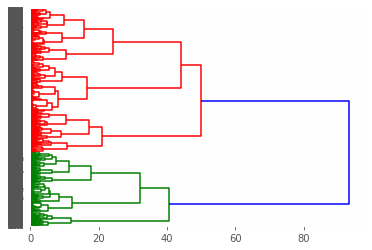

In [46]:
dn = dendrogram(link, orientation='right')

По дендрограмме можно выделить 11 кластеров

In [47]:
normalized_df['cluster'] = fcluster(link, 11, criterion='maxclust')

In [48]:
normalized_df.groupby('cluster').mean()

,children,dob_years,education_id,family_status_id,gender_id,purpose_id,total_income
cluster,,,,,,,
1,0.046240,0.307900,0.218400,0.938600,1.0,0.194400,0.071218
2,0.120583,0.415957,0.208796,0.027884,1.0,0.000383,0.078672
3,0.102209,0.397722,0.205081,0.250000,1.0,1.000000,0.075282
4,0.122282,0.423767,0.209911,0.028652,1.0,0.495163,0.078456
5,0.020575,0.650595,0.258065,0.419137,0.0,0.242081,0.054505
6,0.065849,0.438881,0.189151,0.905425,0.0,0.498113,0.061737
7,0.063783,0.439909,0.181268,0.893145,0.0,0.000733,0.064846
8,0.041276,0.575496,0.225969,0.009491,0.0,0.004577,0.059775
9,0.193210,0.264033,0.170369,0.046306,0.0,0.000000,0.059207


In [49]:
df = df.join(normalized_df['cluster'])

In [50]:
df.groupby('cluster').mean()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,purpose_id,gender_id
cluster,,,,,,,,,
1.0,0.231200,18590.350828,36.242400,0.873600,3.754400,0.141600,180546.302046,0.583200,1.0
2.0,0.602913,37151.187276,42.293599,0.835186,0.111537,0.086240,197280.783179,0.001150,1.0
3.0,0.511046,36538.002679,41.272459,0.820324,1.000000,0.092784,189671.225865,3.000000,1.0
4.0,0.611412,36438.678274,42.730939,0.839646,0.114609,0.102312,196795.996380,1.485489,1.0
5.0,0.102877,179749.559947,55.433304,1.032258,1.676548,0.061901,143026.907408,0.726242,0.0
6.0,0.329245,75066.303096,43.577358,0.756604,3.621698,0.072642,159261.928137,1.494340,0.0
7.0,0.318915,69719.274762,43.634897,0.725073,3.572581,0.061584,166242.340068,0.002199,0.0
8.0,0.206381,116048.370459,51.227787,0.903877,0.037964,0.052100,154858.348646,0.013732,0.0
9.0,0.966051,-339.269333,33.785821,0.681478,0.185222,0.084373,153582.169289,0.000000,0.0


In [51]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_id,gender_id,cluster
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,на недвижимость,0,0,9.0
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,на автомобиль,1,0,11.0
2,0,-5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,на недвижимость,0,1,2.0
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,на образование,2,1,4.0
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,на свадьбу,3,0,10.0


In [52]:
for i, data in df.groupby('cluster'):
  print('Кластер', i)
  print()
  print("Количество детей \n", data['children'].value_counts() / data['children'].value_counts().sum())
  print()
  print(f"Средний возраст: {data['dob_years'].mean():.0f}")
  print()
  print("Образование \n", data['education'].value_counts() / data['education'].value_counts().sum())
  print()
  print("Семейное положение \n", data['family_status'].value_counts() / data['family_status'].value_counts().sum())
  print()
  print("Пол \n", data['gender'].value_counts())
  print()
  print(f"Средний доход: {data['total_income'].mean()}")
  print()
  print("Цель получения кредита \n", data['purpose'].value_counts() / data['purpose'].value_counts().sum())
  print()
  print(f"Процент просрочек: {data['debt'].mean():.2%}")
  print()

Кластер 1.0

Количество детей 
 0    0.8096
1    0.1520
2    0.0360
3    0.0024
Name: children, dtype: float64

Средний возраст: 36

Образование 
 среднее                0.6512
высшее                 0.2504
неоконченное высшее    0.0744
начальное              0.0224
ученая степень         0.0016
Name: education, dtype: float64

Семейное положение 
 Не женат / не замужем    0.7816
в разводе                0.1912
вдовец / вдова           0.0272
Name: family_status, dtype: float64

Пол 
 M    1250
Name: gender, dtype: int64

Средний доход: 180546.30204622677

Цель получения кредита 
 на недвижимость    0.6008
на автомобиль      0.2152
на образование     0.1840
Name: purpose, dtype: float64

Процент просрочек: 14.16%

Кластер 2.0

Количество детей 
 0    0.579149
1    0.265236
2    0.132235
3    0.020698
4    0.002300
5    0.000383
Name: children, dtype: float64

Средний возраст: 42

Образование 
 среднее                0.729015
высшее                 0.226140
неоконченное высшее    0.0287

**Итоги кластеризации:**

Среди мужчин:

1. Холостые молодые люди отдают кредит хуже всего, вне зависимости от уровня образования, дохода или цели кредита (**процент просрочек: 14.16%**).
2. Лучше всего отдают кредит мужчины среднего возраста, женатые или в гражданском браке, целью кредита которых были операции с недвижимостью (**процент просрочек: 8.62%**).
3. Мужчины, находящиеся в гражданском браке и берущие кредит на свадьбу, **имеют просрочку по кридиту в 9.28% случаев**.
4. Остальные мужчины **имеют просрочку по кридиту в 10.23%
 случаев**.  

Среди женщин:
 
1. Замужние / в гражданском браке девушки, чаще всего имеющие детей и берущие кредит на операции с недвижимостью, имеют больше всего просрочек по кредиту (**процент просрочек: 8.44%**).
2. Примерно такую же долю просрочек имеют женщины среднего возраста, замужние или в гражданском браке, берущие кредит на автомобиль или образование (**процент просрочек: 8.21%**).
3. Лучше всего отдают кредит замужние женщины с средним возрастом 51 год, целью кредита которых были операции с недвижимостью (**процент просрочек: 5.21%**).
4. Незамужние / в разводе / вдовы среднего возраста без детей или с одним, берущие кредит на недвижимость, **имеют просрочку по кридиту в 6.16% случаев**.
5. Похожую долю просрочек имеют женщины предпенсионного возраста без детей, берущие кредит на недвижимость, автомобиль или образование (**процент просрочек: 6.19%**).
6. Женщины среднего возраста, находящиеся в гражданском браке и берущие кредит на свадьбу, **имеют просрочку по кридиту в 6.71% случаев**.
7. Незамужние / в разводе / вдовы среднего возраста без детей или с одним, берущие кредит на автомобиль или образование, **имеют просрочку по кридиту в 7.26% случаев**.


## Метод k-средних

In [53]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 2, random_state = 42)

In [54]:
model.fit(normalized_df.drop('cluster', axis=1).values.reshape(-1, 1))

KMeans(n_clusters=2, random_state=42)

In [55]:
model.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

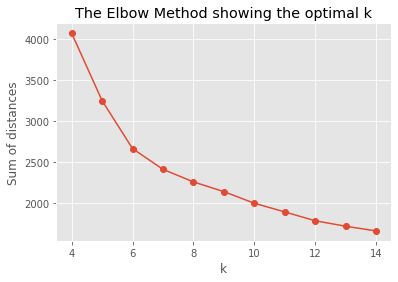

In [56]:
K = range(4, 15)

models = [KMeans(n_clusters=k, random_state=42).fit(normalized_df.drop('cluster', axis=1).values) for k in K]
dist = [model.inertia_ for model in models]

plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

После 7 кластеров сумма расстояний падает не так сильно, поэтому остановимся на этом количестве кластеров

In [57]:
model = KMeans(n_clusters = 7, random_state = 42)
model.fit(normalized_df.drop('cluster', axis=1).values)
normalized_df['cluster2'] = model.labels_
normalized_df.groupby('cluster2').mean()

,children,dob_years,education_id,family_status_id,gender_id,purpose_id,total_income,cluster
cluster2,,,,,,,,
0,0.120369,0.421670,0.208582,0.031776,1.0,0.094967,0.078316,2.559750
1,0.046557,0.298785,0.217623,0.949385,1.0,0.196995,0.071672,1.008197
2,0.094179,0.461310,0.204657,0.153493,0.0,0.810253,0.057978,10.105086
3,0.016222,0.640968,0.220039,0.102301,0.0,0.092993,0.057257,7.981476
4,0.063514,0.435691,0.195067,0.897574,0.0,0.219867,0.062897,6.491235
5,0.186502,0.279458,0.185593,0.039246,0.0,0.093799,0.060715,9.316901
6,0.114080,0.410169,0.209856,0.119083,1.0,0.802676,0.077348,3.584182


In [58]:
df = df.join(normalized_df['cluster2'])

In [59]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_id,gender_id,cluster,cluster2
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,на недвижимость,0,0,9.0,5.0
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,на автомобиль,1,0,11.0,5.0
2,0,-5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,на недвижимость,0,1,2.0,0.0
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,на образование,2,1,4.0,6.0
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,на свадьбу,3,0,10.0,2.0


In [60]:
for i, data in df.groupby('cluster2'):
  print('Кластер', i)
  print()
  print("Количество детей \n", data['children'].value_counts() / data['children'].value_counts().sum())
  print()
  print(f"Средний возраст: {data['dob_years'].mean():.0f}")
  print()
  print("Образование \n", data['education'].value_counts() / data['education'].value_counts().sum())
  print()
  print("Семейное положение \n", data['family_status'].value_counts() / data['family_status'].value_counts().sum())
  print()
  print("Пол \n", data['gender'].value_counts())
  print()
  print(f"Средний доход: {data['total_income'].mean()}")
  print()
  print("Цель получения кредита \n", data['purpose'].value_counts() / data['purpose'].value_counts().sum())
  print()
  print(f"Процент просрочек: {data['debt'].mean():.2%}")
  print()

Кластер 0.0

Количество детей 
 0    0.578490
1    0.266703
2    0.131993
3    0.020369
4    0.002173
5    0.000272
Name: children, dtype: float64

Средний возраст: 43

Образование 
 среднее                0.725149
высшее                 0.228952
неоконченное высшее    0.028789
начальное              0.016839
ученая степень         0.000272
Name: education, dtype: float64

Семейное положение 
 женат / замужем     0.884030
гражданский брак    0.104834
вдовец / вдова      0.011135
Name: family_status, dtype: float64

Пол 
 M    3682
Name: gender, dtype: int64

Средний доход: 196482.66317722976

Цель получения кредита 
 на недвижимость    0.7151
на автомобиль      0.2849
Name: purpose, dtype: float64

Процент просрочек: 9.13%

Кластер 1.0

Количество детей 
 0    0.808197
1    0.153279
2    0.036066
3    0.002459
Name: children, dtype: float64

Средний возраст: 36

Образование 
 среднее                0.652459
высшее                 0.250000
неоконченное высшее    0.076230
начальное      

**Итоги кластеризации**

Среди мужчин:

1. Холостые молодые люди отдают кредит хуже всего, вне зависимости от уровня образования, дохода или цели кредита (**процент просрочек: 14.02%**).
2. Лучше всего отдают кредит мужчины среднего возраста, большиство женатые, некоторые в гражданском браке, целью кредита которых были операции с недвижимостью или покупка автомобиля (**процент просрочек: 8.62%**).
3. Женатые или в гражданском браке мужчины среднего возраста, берущие кредит на образование или свадьбу, **имеют просрочку по кридиту в 9.95% случаев.**

Среди женщин:

1. Замужние / в гражданском браке девушки, чаще всего имеющие детей и берущие кредит на операции с недвижимостью или автомобиль, имеют больше всего просрочек по кредиту (**процент просрочек: 8.86%**).
2. Замужние / в гражданском браке / вдовы в предпренсионном возрасте, не имеющие детей и берущие кредит на операции с недвижимостью или автомобиль, **имеют просрочку по кридиту в 5.02% случаев.**
3. Незамужние или в разводе женщины в среднем возрасте без детей или с одним ребёнком, берущие кредит на недвижимость / автомобиль / образование, **имеют просрочку по кридиту в 6.64% случаев.**
4. В гражданском браке / замужние женщины среднего возраста, берущие кредит на образование или свадьбу, **имеют просрочку по кридиту в 7.54% случаев.**


# Вывод

1. Обработаны пропуски в данных
2. Выявлены аномальные данные в столбце days_employed и children
3. Проведена иерархическая кластеризация и кластеризация по методу k-средних
4. В целом кластеризации дали похожий результат:
  *   Обе кластеризации выделили холостых молодых людей 
  *   Обе кластеризации выделили девушек с детьми
  *   Обе кластеризации выделили женщин в предпенсионном возрасте
  *   Так как в k-кластерном анализе было меньше групп, то остальные кластеры, выделенные при иерархической кластеризации были разделены между оставшимися кластерами по методу k-средних
5. Мужчины отдают кредиты в целом хуже: худшая группа среди женщин отдает кредиты на уровне лучшей группы среди мужчин
6. Самой надежной группой заемщиков оказались замужние / в гражданском браке / вдовы в предпренсионном возрасте, не имеющие детей и берущие кредит на операции с недвижимостью или автомобиль (процент просрочек: 5.02%).
7. Самой ненадежной группой заемщиков оказались холостые молодые люди отдают кредит хуже всего, вне зависимости от уровня образования, дохода или цели кредита (процент просрочек: 14.02%).

